#  Descubra quem fez o ENEM 2016 apenas para treino

Neste desafio deverá descobrir quais estudantes estão fazendo a prova apenas para treino.

#### Detalhes

O contexto do desafio gira em torno dos resultados do ENEM 2016 (disponíveis no arquivo train.csv). Este arquivo, e apenas ele, deve ser utilizado para todos os desafios. Qualquer dúvida a respeito das colunas, consulte o [Dicionário dos Microdados do Enem 2016](https://s3-us-west-1.amazonaws.com/acceleration-assets-highway/data-science/dicionario-de-dados.zip).

Alguns estudantes decidem realizar prova do ENEM de forma precoce, como um teste (coluna IN_TREINEIRO). Neste desafio, você deve criar um modelo de classificação binária para inferir a mesma. Os resultados possíveis da sua resposta devem ser “0” ou “1”.

Salve sua resposta em um arquivo chamado answer.csv com duas colunas: `NU_INSCRICAO` e `IN_TREINEIRO`.

In [144]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

import warnings
warnings.simplefilter(action = 'ignore')


### Carregando dados

In [73]:
# Lendo dados
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [74]:
train.head(2)

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A


In [75]:
test.head(2)

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,43,RS,19,F,1,1,1,3,1,...,NaN,NaN,E,E,H,B,B,C,D,A
1,177f281c68fa032aedbd842a745da68490926cd2,15,PA,24,M,3,2,1,4,1,...,NaN,NaN,B,C,B,A,A,C,D,A


In [77]:
# Dropando algumas colunas
test.drop(columns=['TP_ENSINO','TP_DEPENDENCIA_ADM_ESC'], inplace=True)

### Encontrando as melhores features

In [78]:
# Selecionando apenas as colunas numéricas da base de teste
number_columns = list(test.select_dtypes(include='number').columns)

In [79]:
# Dividindo o dataset de treino em features e target
x = train[number_columns]
y = train.IN_TREINEIRO

# Eliminando valores nulos na base de teste, substituindo por 0
x.fillna(0, inplace=True)
y.fillna(0, inplace=True)

In [80]:
# Utilizando a função SelectKBest para encontrar as melhores features
selector = SelectKBest(f_classif, k=8)

# Aplicando a função nas features e target para encontrar as melhores features
x_new = selector.fit_transform(x, y)

In [116]:
# Lista das posições das features escolhidas
features = list(selector.get_support(indices=True))

# Utilizando as posições para encontrar as features que serão utilizadas como base
base = []
for x in features:
    base.append(number_columns[x])
base.append('IN_TREINEIRO')

### Analise do Dados

In [117]:
# Gerando uma base para analise
df = train[base]

#Definindo features e target
features = df.drop(["IN_TREINEIRO"], axis=1)
target = df.IN_TREINEIRO

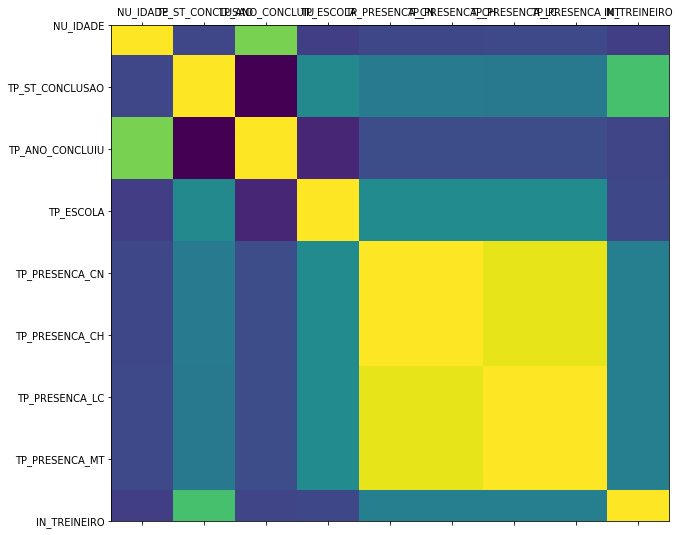

In [118]:
# Grafico de correlação entre as variáveis
def plot_corr(X, size=10):
    corr = X.corr()  
    fig, zx = plt.subplots(figsize = (size, size))
    zx.matshow(corr)  
    plt.xticks(range(len(corr.columns)), corr.columns) 
    plt.yticks(range(len(corr.columns)), corr.columns)  
plot_corr(df)

In [119]:
# Verificando as colunas selecionadas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   NU_IDADE         13730 non-null  int64
 1   TP_ST_CONCLUSAO  13730 non-null  int64
 2   TP_ANO_CONCLUIU  13730 non-null  int64
 3   TP_ESCOLA        13730 non-null  int64
 4   TP_PRESENCA_CN   13730 non-null  int64
 5   TP_PRESENCA_CH   13730 non-null  int64
 6   TP_PRESENCA_LC   13730 non-null  int64
 7   TP_PRESENCA_MT   13730 non-null  int64
 8   IN_TREINEIRO     13730 non-null  int64
dtypes: int64(9)
memory usage: 965.5 KB


In [120]:
# Verificando a quantidade de nulos
df.isna().sum()

NU_IDADE           0
TP_ST_CONCLUSAO    0
TP_ANO_CONCLUIU    0
TP_ESCOLA          0
TP_PRESENCA_CN     0
TP_PRESENCA_CH     0
TP_PRESENCA_LC     0
TP_PRESENCA_MT     0
IN_TREINEIRO       0
dtype: int64

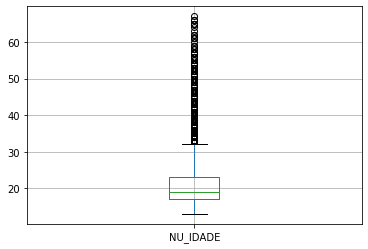

In [121]:
# Verificando outliers na coluna NU_IDADE
df[['NU_IDADE']].boxplot();

In [122]:
# Verificando a proporção da coluna IN_TREINEIRO
df.IN_TREINEIRO.value_counts()

0    11947
1     1783
Name: IN_TREINEIRO, dtype: int64

In [123]:
# VErificando a proporção percentual
df.IN_TREINEIRO.value_counts()/df.shape[0]*100

0    87.013838
1    12.986162
Name: IN_TREINEIRO, dtype: float64

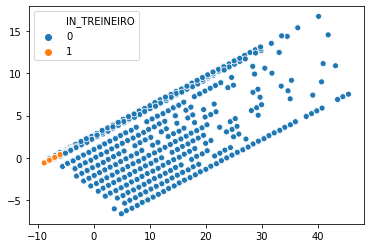

In [124]:
# Utilizando PCA para ver de forma gáfica a proporção
pca = PCA(n_components=2)
pca.fit(features)
imbalanced_pca = pca.transform(features)
sns.scatterplot(imbalanced_pca[:, 0], imbalanced_pca[:, 1], hue=target);

### Realizando Balanceamento dos Dados

In [128]:
# Aplicando SMOTE, técnicas de reamostragem oversampling que adiciona dados sintéticos à classe minitoritária
smote = SMOTE(sampling_strategy="minority")
x_smote, y_smote = smote.fit_resample(features, target)

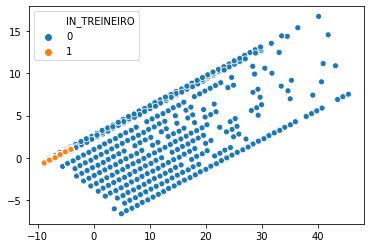

In [129]:
# Verificando o novo balanceamento após aplicação do SMOTE a quantidade de 1 aumentou apesar de não está tão visível no gráfico
imbalanced_pca_smote = pca.transform(x_smote)
sns.scatterplot(x=imbalanced_pca_smote[:, 0], y=imbalanced_pca_smote[:, 1], hue=y_smote);

In [134]:
print('\nValores Desbalanceados\n')
print(target.value_counts())
print('\nValores Balanceados\n')
print(y_smote.value_counts())


Valores Desbalanceados

0    11947
1     1783
Name: IN_TREINEIRO, dtype: int64

Valores Balanceados

1    11947
0    11947
Name: IN_TREINEIRO, dtype: int64


### Analise dos Modelos de Classificação

In [135]:
# Definindo dados de treino e teste
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.2)

In [203]:
# Função para analise dos modelos
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(x_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(x_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    matrix = metrics.confusion_matrix(y_test, pred)
    report = metrics.classification_report(y_test, pred)
    print("accuracy:   %0.3f" % score)
    print("*************** Classification Report ***************")
    print(report)
    print("Confusion Matrix")
    sns.heatmap(matrix, annot=True)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time, clf

BaggingClassifier
________________________________________________________________________________
Training: 
BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
train time: 0.099s
test time:  0.011s
accuracy:   0.990
*************** Classification Report ***************
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2450
           1       0.98      1.00      0.99      2329

    accuracy                           0.99      4779
   macro avg       0.99      0.99      0.99      4779
weighted avg       0.99      0.99      0.99      4779

Confusion Matrix



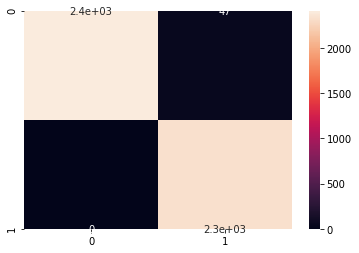

In [204]:
results = []
print('=' * 80)
print('BaggingClassifier')
results.append(benchmark((BaggingClassifier())))

RandomForestClassifier
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
train time: 0.587s
test time:  0.062s
accuracy:   0.990
*************** Classification Report ***************
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2450
           1       0.98      1.00      0.99      2329

    accuracy                           0.99      4779
   macro a

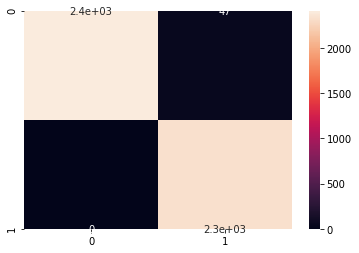

In [205]:
print('=' * 80)
print('RandomForestClassifier')
results.append(benchmark((RandomForestClassifier())))

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
train time: 0.159s
test time:  0.001s
accuracy:   0.988
*************** Classification Report ***************
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2450
           1       0.98      1.00      0.99      2329

    accuracy                           0.99      4779
   macro avg       0.99      0.99      0.99      4779
weighted avg       0.99      0.99      0.99      4779

Confusion Matrix



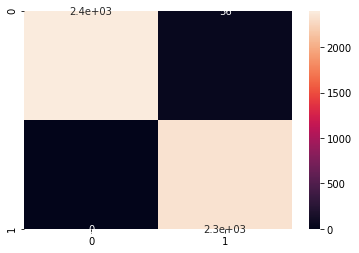

In [206]:
print('=' * 80)
print('LogisticRegression')
results.append(benchmark((LogisticRegression())))

KNeighborsClassifier
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
train time: 0.248s
test time:  0.480s
accuracy:   0.991
*************** Classification Report ***************
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2450
           1       0.99      0.99      0.99      2329

    accuracy                           0.99      4779
   macro avg       0.99      0.99      0.99      4779
weighted avg       0.99      0.99      0.99      4779

Confusion Matrix



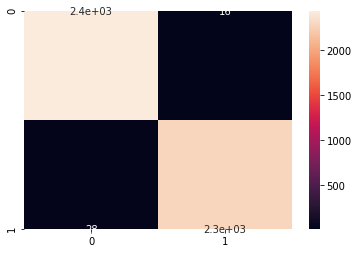

In [207]:
print('=' * 80)
print('KNeighborsClassifier')
results.append(benchmark((KNeighborsClassifier())))

DecisionTreeClassifier
________________________________________________________________________________
Training: 
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
train time: 0.009s
test time:  0.002s
accuracy:   0.990
*************** Classification Report ***************
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2450
           1       0.98      1.00      0.99      2329

    accuracy                           0.99      4779
   macro avg       0.99      0.99      0.99      4779
weighted avg       0.99      0.99      0.99      4779

Confusion Matrix



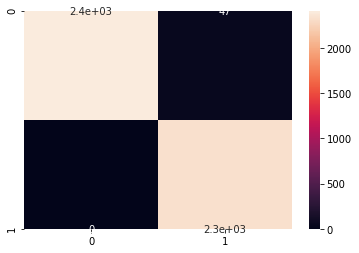

In [208]:
print('=' * 80)
print('DecisionTreeClassifier')
results.append(benchmark((DecisionTreeClassifier())))

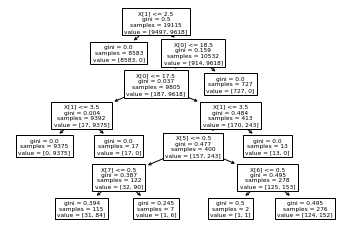

In [209]:
# Gerando a arvore de decisão de forma gráfica
decision_tree_fitted = DecisionTreeClassifier().fit(x_train, y_train)
plot_tree(decision_tree_fitted);

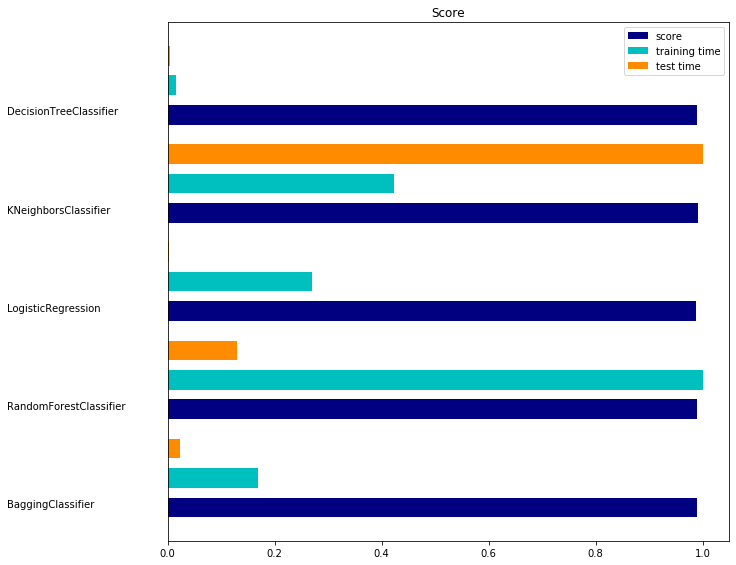

In [210]:
# Resultado da analise os modelos
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

### Seleção do Modelo

________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
train time: 0.220s
test time:  0.475s
accuracy:   0.991
*************** Classification Report ***************
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2450
           1       0.99      0.99      0.99      2329

    accuracy                           0.99      4779
   macro avg       0.99      0.99      0.99      4779
weighted avg       0.99      0.99      0.99      4779

Confusion Matrix



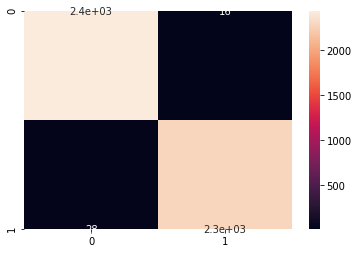

In [211]:
model = benchmark(KNeighborsClassifier())[4]

### Prevendo com os Dados de Teste

In [217]:
# Preparando base de teste
df2 = test[list(features.columns)]

# Eliminando valores nulos na base de teste, não existe nulos nas fetures selecionadas df2.isna().sum()
#df2.fillna(0, inplace=True)

# Realizando a predição
df2['IN_TREINEIRO'] = model.predict(df2)

# Inserindo os numeros de inscrição
df2['NU_INSCRICAO'] = test['NU_INSCRICAO']

# Preparando df para exportação
df2 = df2[['NU_INSCRICAO', 'IN_TREINEIRO']]

# Exportação da predição para csv
df2.to_csv('answer.csv', index=False)
df2

,NU_INSCRICAO,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
1,177f281c68fa032aedbd842a745da68490926cd2,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,1
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0
...,...,...
4565,361b7fcd8867119550fe2af5aa729ffad89a7cf5,0
4566,d8a0e4c9e29494cc9bba2422bd79333931475ee1,0
4567,3f1c3388244df8d6521e983a809292d9f3bca643,0
4568,1778e9c4cef591beb6b986d191d15ed05de816b0,0
